In [1]:
 
ngram_length = 3
dstype = 'comp' 
mname = 'debertaV3'

In [2]:
from colorama import Fore, Style

import os

In [3]:
path = f"/home/bhairavi/om/om3/{dstype}/{ngram_length}grams_{mname}/"
os.makedirs(path, exist_ok=True)

print("Directory created or already exists.")
 

file_path = path + f'{dstype}_{ngram_length}keys.csv' 
print(Fore.YELLOW,"csv_filePATH--->",file_path)


filepath_full = path + f'{dstype}_{ngram_length}top5.csv' 
print(Fore.YELLOW,"QUE_filePATH--->",filepath_full)
 
 
 
modelpath = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"

 

print(Fore.YELLOW,'modelPATH--->',modelpath)
 


Directory created or already exists.
 csv_filePATH---> /home/bhairavi/om/om3/comp/3grams_debertaV3/comp_3keys.csv
 QUE_filePATH---> /home/bhairavi/om/om3/comp/3grams_debertaV3/comp_3top5.csv
 modelPATH---> /home/bhairavi/om/om5/comp/debertaV3_comp


In [4]:

 
 
import torch  

torch.cuda.empty_cache()  
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertForSequenceClassification, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 


# %%
from collections import defaultdict
import string
 
import torch.nn.functional as F
from nltk.util import ngrams

import numpy as np  
  


/home/bhairavi/om/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Map: 100%|██████████| 8122/8122 [00:03<00:00, 2330.87 examples/s]


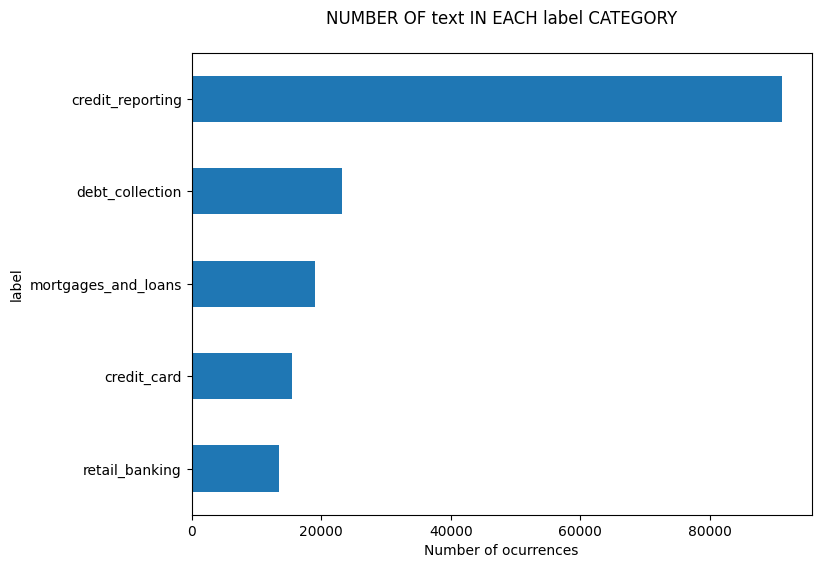

In [5]:


# %%
df = pd.read_csv('/home/bhairavi/om/om5/complaints/complaints.csv')
df.shape

# %%
df['narrative'].dropna(inplace=True)
df.shape

# %%

# %%

# %%
df.sample(5)


# %%


# %%
df.drop(columns=["Unnamed: 0"], inplace=True)
df.columns = (['label','text' ])


# %%
df[0:3]

# %%


# %%


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


# %%
df.columns

# %%
numlabel = df['target'].nunique()
numlabel


# %%
df['text'] = df['text'].apply(lambda x: str(x)[:512] if isinstance(x, float) else x[:512])


# %%
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

# %%
# df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# # Calculate the maximum token length
# max_length = df['token_length'].max()

# # Calculate the next maximum token length
# next_max_token_length = df['token_length'].nlargest(2).iloc[1]

# # Calculate the average token length
# average_token_length = df['token_length'].mean()

# # Display the results
# print(f"Maximum token length: {max_length}")
# print(f"Next maximum token length: {next_max_token_length}")
# print(f"Average token length: {average_token_length:.2f}")

# %%
max_length = 512

# %%

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)





In [6]:


# %%


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 

 
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

 




/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:

 
io=   pd.DataFrame(eval_dataset)
 
batch_size = 4

# Convert your DataFrame to a list of texts
texts = io['text'].tolist()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the specified device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Initialize lists to store predictions
    all_predictions = []
    
    # Process data in batches
    for start in range(0, len(texts), batch_size):
        end = start + batch_size
        batch_texts = texts[start:end]
        
        # Tokenize the batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
        # Move inputs to the same device as model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get predictions
        outputs = model(**inputs)
        # Apply softmax to get probabilities from the logits
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        # Get the predicted class indices
        predicted_indices = torch.argmax(probabilities, dim=1)
        
        # Ensure the indices are back on CPU for DataFrame operations
        predicted_indices = predicted_indices.cpu()
        
        # Convert indices to actual labels if labels are strings
        if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
            predicted_labels = [tokenizer.get_labels()[idx] for idx in predicted_indices]
        else:
            predicted_labels = predicted_indices.tolist()
        
        # Append batch predictions to the list
        all_predictions.extend(predicted_labels)

# Add predictions to DataFrame
io['predicted_label'] = all_predictions
 


In [8]:
 

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# %%
top_n = 5
 
 
 
     


In [9]:
     


io[f'significant_{ngram_length}grams'] = None
io[f'{ngram_length}gram_weights'] = None 

def occlusion(text, model, tokenizer, label, ngram_length, device):
    """
    Perform occlusion on the text and return n-gram importances based on the specified n-gram length.
    """
    inputs = tokenizer(text, return_tensors='pt').to(device)
    original_logits = model(**inputs).logits
    original_probs = F.softmax(original_logits, dim=-1)
    original_prediction = original_probs[0][label].item()
    
    ngram_importances = defaultdict(float)
    words = text.split()
    ngrams_list = list(ngrams(words, ngram_length))
    
    for ngram in ngrams_list:
        occluded_text = " ".join([word if word not in ngram else "[OCCLUDED]" for word in words])
        occluded_inputs = tokenizer(occluded_text, return_tensors='pt').to(device)
        occluded_logits = model(**occluded_inputs).logits
        occluded_probs = F.softmax(occluded_logits, dim=-1)
        occluded_prediction = occluded_probs[0][label].item()
        
        ngram_importances[" ".join(ngram)] = original_prediction - occluded_prediction
        
    return ngram_importances

def aggregate_and_filter_positive_attributions(ngram_attributions, threshold=0):
    significant_ngrams = {
        ngram: value for ngram, value in ngram_attributions.items()
        if value > threshold
    }
    return significant_ngrams

def select_top_ngrams(ngram_importances, top_n=top_n):
    sorted_ngrams = sorted(ngram_importances.items(), key=lambda item: item[1], reverse=True)
    top_ngrams = sorted_ngrams[:top_n]
    return top_ngrams

# Assuming 'io' DataFrame exists and is properly formatted
for index, row in io.iterrows():
    if row['target'] == row['predicted_label']:  # Only proceed if prediction matches the label

        ngram_attributions = occlusion(row['text'], model, tokenizer, row['label'], ngram_length, device)
        positive_attributions = aggregate_and_filter_positive_attributions(ngram_attributions)
        top_ngrams = select_top_ngrams(positive_attributions, top_n=top_n)  # Ensure top_n is appropriately set
        
        # Store significant n-grams
        io.at[index, f'significant_{ngram_length}grams'] = [ngram for ngram, _ in top_ngrams]  # Rename this column to 'significant_ngrams'
        # Store weights
        io.at[index, f'{ngram_length}gram_weights'] = [weight for _, weight in top_ngrams]  # Rename this column to 'ngram_weights'


In [10]:

io.to_csv(filepath_full,index= False)

io[0:4]

,label,text,target,__index_level_0__,input_ids,token_type_ids,attention_mask,predicted_label,significant_3grams,3gram_weights
0,3,made application refinance mortgage applicatio...,3,148698,"[1, 412, 1055, 26934, 4252, 1055, 823, 788, 37...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3,"[application refinance mortgage, refinance mor...","[0.9891502850223333, 0.9891502850223333, 0.988..."
1,1,many time tried get company collect proper inf...,1,95877,"[1, 386, 326, 1367, 350, 483, 3268, 2219, 439,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",2,None,None
2,4,chase bank released fund fake check account ca...,4,11134,"[1, 9603, 1831, 1315, 2842, 5083, 807, 914, 65...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4,"[bank released fund, fund fake check, fund fra...","[0.9375299029052258, 0.8841703310608864, 0.827..."
3,1,disputed credit report identity theft mail sen...,1,55225,"[1, 18968, 1236, 815, 3044, 8009, 3447, 1253, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,[],[]


In [11]:
 
io[f'significant_{ngram_length}grams'][0]
 
 


['application refinance mortgage',
 'refinance mortgage application',
 'mortgage broker refinance',
 'broker refinance mortgage',
 'refinance mortgage asap']

In [12]:


# %%

 
io['text'][0], io[f'significant_{ngram_length}grams'][0]



('made application refinance mortgage application almost month well fargo since took mortgage first time home buyer back interest rate significantly high current rate refinance interest came advised mortgage broker refinance mortgage asap submitted document first shot hence well fargo representative kept asking document giving blame delay processing become frustrating since waiting month closing date well fargo correspondent u proposing closing date mean didnt applied forbearance made wellsfargo comfortable e',
 ['application refinance mortgage',
  'refinance mortgage application',
  'mortgage broker refinance',
  'broker refinance mortgage',
  'refinance mortgage asap'])

In [13]:

# %%

# %%
io['label'] = le.inverse_transform(io['target'])

 


In [14]:


# %%
io= io.dropna()

# %%


In [15]:
# label_to_words = io.groupby('label')['significant_words'].apply(lambda words: set().union(*words)).to_dict()
label_to_words = io.groupby('label')[f'significant_{ngram_length}grams'].apply(lambda words: set().union(*words)).to_dict()
# label_to_words = io.groupby('label')['significant_5grams'].apply(lambda words: set().union(*words)).to_dict()
 
print(label_to_words)



{'credit_card': {'payment told csr', 'credit card platinum', 'card final purchase', 'complaint addition cfpb', 'reached company issue', 'always bite dust', 'american express month', 'summarize concern order', 'american express continues', 'closure furloughed boyfriend', 'account closed bank', 'express early pandemic', 'refund capital one', 'fax response barclay', 'card account notified', 'credit card transaction', 'got customer service', 'credit line refused', 'closed account wait', 'visa replaced card', 'adding interest charged', 'unemployment benefit requested', 'tried using card', 'account company year', 'td retail card', 'told credit line', 'back contact amex', 'capital one quicksilver', 'card apply received', 'southwest card past', 'citibank increased interest', 'purchased prepaid netspend', 'american express blue', 'received item listed', 'use card day', 'discover card like', 'carecredit mastercard moved', 'statement used message', 'card number wallet', 'complain bank america', '

In [16]:

# %%

# %%




label_to_words_and_weights = {}

for label, group in io.groupby('label'):
    word_weights_dict = {}
    for index, row in group.iterrows():
        words = row[f'significant_{ngram_length}grams']
        weights = row[f'{ngram_length}gram_weights']
        for word, weight in zip(words, weights):
            if word in word_weights_dict:
                # Take the maximum of the existing and current weight
                word_weights_dict[word] = max(word_weights_dict[word], weight)
            else:
                word_weights_dict[word] = weight
    label_to_words_and_weights[label] = word_weights_dict

# Display the dictionary with labels, words, and their maximum weights
print(label_to_words_and_weights)


{'credit_card': {'charged annual fee': 0.5129616856575012, 'customer service barclays': 0.4971669614315033, 'fee ask continued': 0.4643319249153137, 'fee told credit': 0.4512147307395935, 'annual fee told': 0.44412487745285034, 'pickup store delivered': 0.9177619652473368, 'pickup store package': 0.9177168738096952, 'online pickup store': 0.9176918443117756, 'item pickup store': 0.9176746394659858, 'pickup store picked': 0.9176731562474743, 'documentation provided merchant': 0.6668201982975006, 'merchant provided documentation': 0.8875141211901791, 'supplemental documentation citi': 0.6083734631538391, 'citi closed claim': 0.582146018743515, 'documentation citi citi': 0.5731871128082275, 'capital one rebilled': 0.9707225153688341, 'calling capital one': 0.9672282179817557, 'capital one heard': 0.9665906252339482, 'call capital one': 0.9769703652709723, 'saw capital one': 0.9609833369031549, 'promotional balance comenity': 0.9849168278160505, 'bank pay promotional': 0.9701960608363152, 

In [18]:

# %%


# %%
label_to_words = label_to_words_and_weights

# %%
# len(list(label_to_words['Acne']))



In [19]:

# %%

# %%
len(label_to_words)



5

In [20]:

# %%

# %%
label_to_words

 


{'credit_card': {'charged annual fee': 0.5129616856575012,
  'customer service barclays': 0.4971669614315033,
  'fee ask continued': 0.4643319249153137,
  'fee told credit': 0.4512147307395935,
  'annual fee told': 0.44412487745285034,
  'pickup store delivered': 0.9177619652473368,
  'pickup store package': 0.9177168738096952,
  'online pickup store': 0.9176918443117756,
  'item pickup store': 0.9176746394659858,
  'pickup store picked': 0.9176731562474743,
  'documentation provided merchant': 0.6668201982975006,
  'merchant provided documentation': 0.8875141211901791,
  'supplemental documentation citi': 0.6083734631538391,
  'citi closed claim': 0.582146018743515,
  'documentation citi citi': 0.5731871128082275,
  'capital one rebilled': 0.9707225153688341,
  'calling capital one': 0.9672282179817557,
  'capital one heard': 0.9665906252339482,
  'call capital one': 0.9769703652709723,
  'saw capital one': 0.9609833369031549,
  'promotional balance comenity': 0.9849168278160505,
  'b

In [21]:

test_data = pd.DataFrame(test_dataset)

 

 
from nltk.tokenize import sent_tokenize, word_tokenize

# %%
def split_text(text):
 
    sentences = sent_tokenize(text)  # Tokenize the text into sentences
    third_index = len(sentences) // 2  # Calculate index for one-third
    first_part = ' '.join(sentences[:third_index])  # First third of sentences
    remaining_part = ' '.join(sentences[third_index:])  # Remaining two-thirds
    return first_part, remaining_part
 
# Apply the function to the DataFrame
test_data[['first_half', 'second_half']] = test_data['text'].apply(lambda x: pd.Series(split_text(x)))


# %%
test_data['first_half'][0:4] , test_data['second_half'][0:4]

# %%

 
# %%


(0    
 1    
 2    
 3    
 Name: first_half, dtype: object,
 0    day waiting response credit bureau inaccurate ...
 1    decided get credit pulled due couple collectio...
 2    applied moneylion loan back first loan went sm...
 3    il last four acct police report affidavit dear...
 Name: second_half, dtype: object)

In [22]:

# %%
tdf = test_data[['first_half', 'label']]
tdf = Dataset.from_pandas(tdf)


 
   
def tokenize_function(examples):
    return tokenizer(examples['first_half'], truncation=True, padding="max_length", max_length=512)

tdf = tdf.map(tokenize_function, batched=True)

# Predict using the trained model
output = trainer.predict(tdf)
predictions = np.argmax(output.predictions, axis=1)
labels = output.label_ids 

# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=np.unique(labels).astype(str),  # Convert labels to string if necessary
    digits=4
)
print(Fore.RED +"first half i.e partial info classification report, baseline 1")
print(report)



Map:   0%|          | 0/8122 [00:00<?, ? examples/s]

Map: 100%|██████████| 8122/8122 [00:01<00:00, 4676.75 examples/s]


/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


first half i.e partial info classification report, baseline 1
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       778
           1     0.5613    1.0000    0.7190      4559
           2     0.0000    0.0000    0.0000      1158
           3     0.0000    0.0000    0.0000       950
           4     0.0000    0.0000    0.0000       677

    accuracy                         0.5613      8122
   macro avg     0.1123    0.2000    0.1438      8122
weighted avg     0.3151    0.5613    0.4036      8122



/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Move model to the specified device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Assuming your DataFrame `io` has a column 'text' containing the text to predict
    texts = test_data['first_half'].tolist()
    # Tokenize the text
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions
    outputs = model(**inputs)
    # Apply softmax to get probabilities from the logits
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    # Get the top 3 predicted class indices and their probabilities
    top_probs, top_indices = torch.topk(probabilities, 3, dim=1)

    # Ensure the indices and probabilities are back on CPU for DataFrame operations
    top_indices = top_indices.cpu()
    top_probs = top_probs.cpu()

    # Convert indices to actual labels if labels are strings
    if hasattr(tokenizer, 'get_labels') and callable(tokenizer.get_labels):
        predicted_labels = [[tokenizer.get_labels()[idx] for idx in indices] for indices in top_indices]
    else:
        predicted_labels = top_indices.tolist()

    # Add top 3 predictions to DataFrame
    test_data['top3_predicted_labels'] = predicted_labels
    test_data['top3_predicted_probabilities'] = top_probs.tolist()


 
test_data = test_data[['text','label','target','first_half','second_half','top3_predicted_labels']]

 
 

# %%
test_data['top3_predicted_target']  =  test_data['top3_predicted_labels']

# %%
test_data['label'] = le.inverse_transform(test_data['target'])

# Decode 'top3_predicted_labels' - since these are lists, we apply the inverse transform in a vectorized manner
test_data['top3_predicted_labels'] = test_data['top3_predicted_labels'].apply(lambda x: le.inverse_transform(x))

 

# %%

# %%
def map_significant_words(predictions):
    print(predictions)
    for row in predictions:
        print(row)
    return [label_to_words.get(row, []) for row in predictions]
    # return [[result[pred] for pred in row] for row in predictions]

# Applying the mapping function
test_data['significant_words'] = test_data['top3_predicted_labels'].apply(map_significant_words)

# %%
test_data


OutOfMemoryError: CUDA out of memory. Tried to allocate 11.90 GiB. GPU 0 has a total capacity of 47.54 GiB of which 6.50 GiB is free. Including non-PyTorch memory, this process has 1.33 GiB memory in use. Process 790346 has 26.56 GiB memory in use. Process 791720 has 9.69 GiB memory in use. Process 797498 has 3.43 GiB memory in use. Of the allocated memory 911.49 MiB is allocated by PyTorch, and 136.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:


# %%

# %%
test_data.to_csv(file_path,index= False)


In [ ]:

# %%
df = test_data

 
df['significant_words'][0]

 


[{'in my legs': 0.488895982503891,
  'my legs are': 0.4594966769218445,
  'veins in my': 0.2333756685256958,
  'legs are causing': 0.23197436332702637,
  'The veins in': 0.08885067701339722,
  'on my legs': 0.17966949939727783,
  'legs that I': 0.07607412338256836,
  'vessels below the': 0.06379151344299316,
  'my legs that': 0.05489623546600342,
  'There is bruising': 0.02944272756576538,
  "My legs' skin": 0.09659463167190552,
  'skin around the': 0.06327491998672485,
  "legs' skin around": 0.043838322162628174,
  'veins is unusual.': 0.042717158794403076,
  'around the veins': 0.036156415939331055,
  'in my calves': 0.9620735943317413,
  'my calves are': 0.3880428671836853,
  'calves are making': 0.24857032299041748,
  'it difficult for': 0.10371333360671997,
  'difficult for me': 0.06708598136901855,
  'The veins on': 0.16718816757202148,
  'veins on my': 0.12512195110321045,
  'lot of discomforts': 0.11622029542922974,
  'of discomforts when': 0.08438414335250854,
  'my calves is'

In [ ]:


# %%
# %%
df.rename(columns={'significant_words': 'significant_words_weights'}, inplace=True)
 


In [ ]:
# %%
len(df['significant_words_weights'][0])


3

In [ ]:

# %%
df['significant_words_weights'][0][0]  

# %%


{'in my legs': 0.488895982503891,
 'my legs are': 0.4594966769218445,
 'veins in my': 0.2333756685256958,
 'legs are causing': 0.23197436332702637,
 'The veins in': 0.08885067701339722,
 'on my legs': 0.17966949939727783,
 'legs that I': 0.07607412338256836,
 'vessels below the': 0.06379151344299316,
 'my legs that': 0.05489623546600342,
 'There is bruising': 0.02944272756576538,
 "My legs' skin": 0.09659463167190552,
 'skin around the': 0.06327491998672485,
 "legs' skin around": 0.043838322162628174,
 'veins is unusual.': 0.042717158794403076,
 'around the veins': 0.036156415939331055,
 'in my calves': 0.9620735943317413,
 'my calves are': 0.3880428671836853,
 'calves are making': 0.24857032299041748,
 'it difficult for': 0.10371333360671997,
 'difficult for me': 0.06708598136901855,
 'The veins on': 0.16718816757202148,
 'veins on my': 0.12512195110321045,
 'lot of discomforts': 0.11622029542922974,
 'of discomforts when': 0.08438414335250854,
 'my calves is': 0.4414995312690735,
 'l

In [ ]:
top_n = 15  # The number of top words you want to select

def filter_top_n_words(list_of_dicts):
    processed_list = []
    
    for index, dct in enumerate(list_of_dicts):
        if isinstance(dct, dict):
            # Sort the items by value in descending order
            sorted_items = sorted(dct.items(), key=lambda item: item[1], reverse=True)
            # Select the top N words
            top_items = sorted_items[:top_n]
            # Extract the keys (words) and add them to the list as a set
            processed_list.append(set(key for key, value in top_items))
        else:
            # Print the index and the problematic element
            print(f"Non-dictionary element at index {index}: {dct}")
            # Optionally, add an empty set or handle differently based on your needs
            processed_list.append(set())
    
    return processed_list

# Apply the function to each element in the DataFrame column
df['significant_words'] = df['significant_words_weights'].apply(filter_top_n_words)


In [ ]:

# %%
df['significant_words'][0][0]  , df['significant_words'][0][1], df['significant_words'][0][2]


# %%


({'Long durations of',
  "My legs' skin",
  'The veins in',
  'The veins on',
  'There is bruising',
  'around the veins',
  'calves are making',
  'calves is constant',
  'difficult for me',
  'have caused severe',
  'in my calves',
  'in my legs',
  'it difficult for',
  'legs are causing',
  'legs that I',
  "legs' skin around",
  'long periods of',
  'lot of discomforts',
  'my calves are',
  'my calves is',
  'my legs are',
  'my legs that',
  'of discomforts when',
  'on my legs',
  'skin around the',
  'stand or walk',
  'standing or walking',
  'veins in my',
  'veins is unusual.',
  'veins on my',
  'vessels below the',
  'walking have caused',
  'worse the longer'},
 {'I get chest',
  'I have a',
  'I occasionally get',
  'I occasionally have',
  "I'm nauseous, ill,",
  'My skin has',
  'My throat always',
  'Sometimes at night',
  'always tickles, and',
  'annoying. I occasionally',
  'around my eyes',
  'breathe. I occasionally',
  'breathing. Sometimes at',
  'can occasion

In [ ]:

# %%
df.shape


# %%


(60, 9)

In [ ]:
 
df['significant_words'][0][0]  , df['significant_words_weights'][0][0] 



({'Long durations of',
  "My legs' skin",
  'The veins in',
  'The veins on',
  'There is bruising',
  'around the veins',
  'calves are making',
  'calves is constant',
  'difficult for me',
  'have caused severe',
  'in my calves',
  'in my legs',
  'it difficult for',
  'legs are causing',
  'legs that I',
  "legs' skin around",
  'long periods of',
  'lot of discomforts',
  'my calves are',
  'my calves is',
  'my legs are',
  'my legs that',
  'of discomforts when',
  'on my legs',
  'skin around the',
  'stand or walk',
  'standing or walking',
  'veins in my',
  'veins is unusual.',
  'veins on my',
  'vessels below the',
  'walking have caused',
  'worse the longer'},
 {'in my legs': 0.488895982503891,
  'my legs are': 0.4594966769218445,
  'veins in my': 0.2333756685256958,
  'legs are causing': 0.23197436332702637,
  'The veins in': 0.08885067701339722,
  'on my legs': 0.17966949939727783,
  'legs that I': 0.07607412338256836,
  'vessels below the': 0.06379151344299316,
  'my

In [ ]:

# %%
# %%
df = df.dropna(ignore_index =True)


In [ ]:
# %%
df.to_csv(file_path ,index= False)

# %%
df.columns


Index(['text', 'label', 'target', 'first_half', 'second_half',
       'top3_predicted_labels', 'top3_predicted_target',
       'significant_words_weights', 'significant_words'],
      dtype='object')

In [ ]:

# %%
len(df['significant_words'][0]),len(df['significant_words'][0][0])

# %


(3, 33)